In [ ]:
!nvidia-smi

Thu Dec 21 06:14:27 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

base_path = '/content/drive/MyDrive/x_ray_chest/results/faster_r_cnn'
ver = 'v1'

# 新しいフォルダを生成
weight_folder = 'weight'
train_folder = 'train'
test_folder = 'test'
test_img_folder = 'images'

weight_folder_path = os.path.join(base_path, ver, weight_folder)
train_folder_path = os.path.join(base_path, ver, train_folder)
test_folder_path = os.path.join(base_path, ver, test_folder)
test_img_path = os.path.join(base_path, ver, test_folder, test_img_folder)

In [ ]:
import sys

def create_folder():

    if os.path.exists(os.path.join(base_path, ver)):
        sys.exit()

    else:
        os.mkdir(os.path.join(base_path, ver))
        os.makedirs(weight_folder_path)
        os.mkdir(train_folder_path)
        os.makedirs(test_img_path)

# フォルダ生成関数の呼び出し
create_folder()

In [3]:
from glob import glob
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
BBox_List_path = '/content/drive/MyDrive/x_ray_chest/BBox_List_2017.csv'
Data_Entry_path = '/content/drive/MyDrive/x_ray_chest/Data_Entry_2017_v2020.csv'

BBox_List_df = pd.read_csv(BBox_List_path)
Data_Entry_df = pd.read_csv(Data_Entry_path)

BBox_List_df.head()

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN


In [ ]:
Data_Entry_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


In [ ]:
print(len(BBox_List_df))
print(len(BBox_List_df.iloc[:,0].unique()))
print(len(Data_Entry_df))
print(len(Data_Entry_df.iloc[:,0].unique()))

984
880
112120
112120


In [ ]:
data_list = BBox_List_df.merge(Data_Entry_df, on='Image Index', how='inner')
data_list = data_list.set_axis(['img_name', 'label', 'bbox_x', 'bbox_y', 'bbox_w', 'bbox_h', 'nan1', 'nan2', 'nan3', 'labels', 'follow_up', 'id', 'age', 'gender', 'view_posi', 'ori_img_w', 'ori_img_h', 'pixel_mm_x', 'pixel_mm_y'], axis=1)
data_list = data_list.drop(['nan1', 'nan2', 'nan3', 'labels', 'follow_up', 'id', 'age', 'gender', 'view_posi', 'pixel_mm_x', 'pixel_mm_y'], axis=1)

data_list.head()

,img_name,label,bbox_x,bbox_y,bbox_w,bbox_h,ori_img_w,ori_img_h
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,2992,2991
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,3056,2544
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,3056,2544
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,2500,2048
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,2500,2048


In [ ]:
data_list['img_name'].value_counts()

00010277_000.png    4
00008814_010.png    3
00018253_059.png    3
00018427_004.png    3
00020482_032.png    3
                   ..
00000756_001.png    1
00008522_032.png    1
00005532_000.png    1
00030206_013.png    1
00026920_000.png    1
Name: img_name, Length: 880, dtype: int64

In [ ]:
import matplotlib.pyplot as plt
import cv2


def image_show(i):

    path_dir = '/content/drive/MyDrive/x_ray_chest/images'

    #labelごとの色を指定
    bbox_color_dict = {'Atelectasis':(255, 0, 0), 'Cardiomegaly':(0, 0, 255), 'Effusion': (50, 205, 50), 'Infiltrate':(255, 255, 0),
                        'Mass':(255, 0, 255), 'Nodule':(0, 255, 255), 'Pneumonia':(255, 192, 203), 'Pneumothorax':(173, 255, 47)}

    text_color_dict = {'Atelectasis':'red', 'Cardiomegaly':'blue', 'Effusion':'limegreen', 'Infiltrate':'y',
                        'Mass':'m', 'Nodule':'aqua', 'Pneumonia':'pink', 'Pneumothorax':'greenyellow'}

    #画像の表示
    file_name = data_list['img_name'].unique()[i]
    img_path = os.path.join(path_dir, file_name)
    img_ori = cv2.imread(img_path)

    #データの取り出し
    row = data_list['img_name'] == file_name
    data = data_list[row]

    #bboxごとにループ
    for i in range(len(data)):

        #bboxの座標を取得
        lx = int(data['bbox_x'].iloc[i])
        ly = int(data['bbox_y'].iloc[i])
        rx = int(data['bbox_x'].iloc[i] + data['bbox_w'].iloc[i])
        ry = int(data['bbox_y'].iloc[i] + data['bbox_h'].iloc[i])

        #ラベルに沿った色を指定
        label_name = data['label'].iloc[i]
        bbox_color = bbox_color_dict[label_name]
        text_color = text_color_dict[label_name]

        #bboxとlabelを表示
        cv2.rectangle(img_ori, (lx, ly), (rx, ry), color=(bbox_color), thickness=5)
        plt.text(lx, ly-10, label_name, color=text_color)

    plt.title(file_name)
    plt.imshow(img_ori)


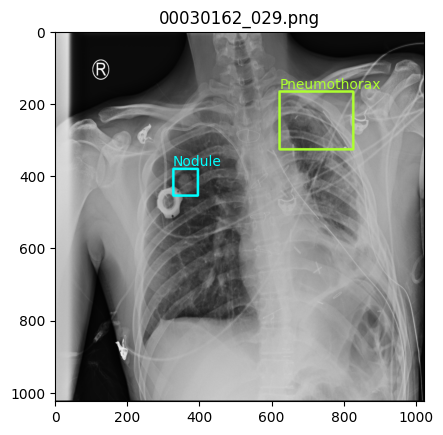

In [ ]:
image_show(654)

In [ ]:
import random

def images_show(row_num, col_num):

    random.seed(42)
    num = [random.randint(0, 880) for i in range(row_num * col_num)]

    path_dir = '/content/drive/MyDrive/x_ray_chest/images'

    #labelごとの色を指定
    bbox_color_dict = {'Atelectasis':(255, 0, 0), 'Cardiomegaly':(0, 0, 255), 'Effusion': (50, 205, 50), 'Infiltrate':(255, 255, 0),
                        'Mass':(255, 0, 255), 'Nodule':(0, 255, 255), 'Pneumonia':(255, 192, 203), 'Pneumothorax':(173, 255, 47)}

    text_color_dict = {'Atelectasis':'red', 'Cardiomegaly':'blue', 'Effusion':'limegreen', 'Infiltrate':'y',
                        'Mass':'m', 'Nodule':'aqua', 'Pneumonia':'pink', 'Pneumothorax':'greenyellow'}

    fig, axes = plt.subplots(nrows=row_num, ncols=col_num, figsize=(15, 10), subplot_kw=({'xticks':(), 'yticks':()}))

    for i, ax in enumerate(axes.flat):

        #画像の表示
        j = num[i]
        file_name = data_list['img_name'].unique()[j]
        img_path = os.path.join(path_dir, file_name)
        img_ori = cv2.imread(img_path)

        #データの取り出し
        row = data_list['img_name'] == file_name
        data = data_list[row]

        #bboxごとにループ
        for k in range(len(data)):

            #bboxの座標を取得
            lx = int(data['bbox_x'].iloc[k])
            ly = int(data['bbox_y'].iloc[k])
            rx = int(data['bbox_x'].iloc[k] + data['bbox_w'].iloc[k])
            ry = int(data['bbox_y'].iloc[k] + data['bbox_h'].iloc[k])

            #ラベルに沿った色を指定
            label_name = data['label'].iloc[k]
            bbox_color = bbox_color_dict[label_name]
            text_color = text_color_dict[label_name]

            #bboxとlabelを表示
            cv2.rectangle(img_ori, (lx, ly), (rx, ry), color=(bbox_color), thickness=5)
            ax.text(lx, ly-10, label_name, color=text_color)

            ax.set_title(data_list['img_name'].unique()[j], fontsize=10)

        ax.imshow(img_ori)


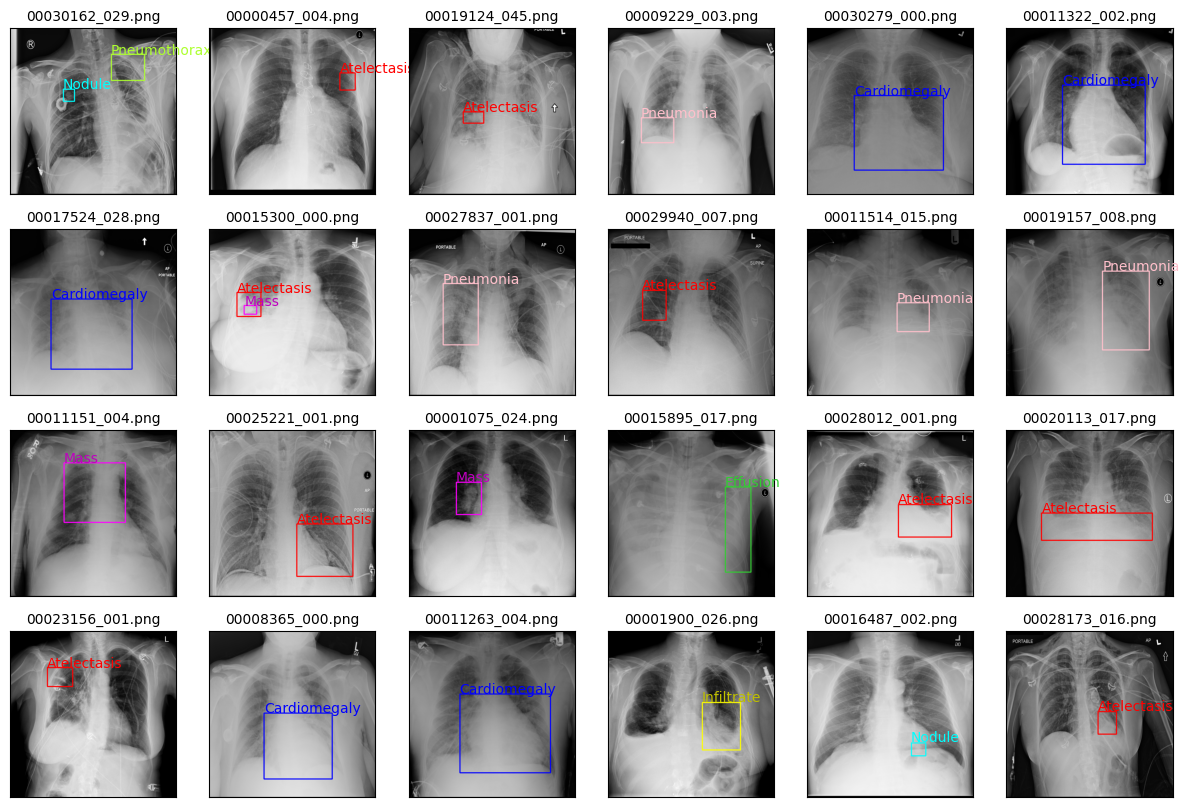

In [ ]:
images_show(4, 6)

In [ ]:
import torch
from torch.utils.data import Dataset
import torchvision
from torchvision import datasets
from torchvision import transforms
import h5py

In [ ]:
# 画像データをimagesに格納

file_path = '/content/drive/MyDrive/x_ray_chest/file.hdf5'

images = []

with h5py.File(file_path, "r") as f:
    group = f["/images"]

    for i in range(len(data_list['img_name'].unique())):
        file_name = data_list['img_name'].unique()[i]

        if file_name in group:
            dataset = group[file_name]
            img_data = np.array(dataset)
            img_tensor = transforms.Compose([transforms.ToTensor()])(img_data)
            images.append(img_tensor)

In [ ]:
boxes = []

for file_name in data_list['img_name'].unique():
    box = []
    row = data_list['img_name'] == file_name
    data = data_list[row]

    for i in range(len(data)):
        lx = data['bbox_x'].iloc[i]
        ly = data['bbox_y'].iloc[i]
        rx = data['bbox_x'].iloc[i] + data['bbox_w'].iloc[i]
        ry = data['bbox_y'].iloc[i] + data['bbox_h'].iloc[i]
        bbox = [lx, ly, rx, ry]
        box.append(bbox)

    box_tensor = torch.tensor(box, dtype = torch.float)

    boxes.append(box_tensor)

In [ ]:
labels = []
label_kind = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltrate', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax']

for file_name in data_list['img_name'].unique():
    label = []
    row = data_list['img_name'] == file_name
    data = data_list[row]

    for i in range(len(data)):
        label_name = data['label'].iloc[i]
        label_index = label_kind.index(label_name)
        label.append(label_index)

    label_tensor = torch.tensor(label, dtype = torch.int64)

    labels.append(label_tensor)

In [ ]:
print(len(images))
print(len(boxes))
print(len(labels))

880
880
880


In [ ]:
dataset = []
for i in range(len(images)):
    data = (images[i], {'boxes':boxes[i], 'labels':labels[i]}, data_list['img_name'].unique()[i])
    dataset.append(data)

In [ ]:
train, val, test = torch.utils.data.random_split(dataset=dataset, lengths=[736, 72, 72], generator=torch.Generator().manual_seed(42))

train_loader = torch.utils.data.DataLoader(train, batch_size = 1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size = 1, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size = 1, shuffle=False)

In [ ]:
train_list = []
val_list = []
test_list = []

[train_list.append(data[2]) for data in train_loader]
[val_list.append(data[2]) for data in val_loader]
[test_list.append(data[2]) for data in test_loader]

train_txt_path = os.path.join(train_folder_path, 'train_list.txt')
val_txt_path = os.path.join(train_folder_path, 'val_list.txt')
test_txt_path = os.path.join(train_folder_path, 'test_list.txt')

with open(train_txt_path, 'w') as f:
    for item in train_list:
        f.write(str(item) + '\n')

with open(val_txt_path, 'w') as f:
    for item in val_list:
        f.write(str(item) + '\n')

with open(test_txt_path, 'w') as f:
    for item in test_list:
        f.write(str(item) + '\n')


In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = (len(label_kind)) + 1
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 176MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
import csv

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.0001)
epochs = 200

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)

loss_train_list=[]
loss_val_list = []

loss_outdir = os.path.join(train_folder_path, 'train_loss.csv')
with open(loss_outdir, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['epoch', 'train loss', 'val loss'])

for epoch in range(epochs):
    model.train()
    loss_train_epo=[]

    for batch in train_loader:
        images, targets, name = batch

        images = list(image.to(device) for image in images)
        boxes = list(box.to(device) for box in targets['boxes'])
        labels = list(label.to(device) for label in targets['labels'])
        targets = list([{'boxes':boxes[i], 'labels':labels[i]} for i in range(len(images))])

        loss_dict = model(images, targets)

        loss = sum(loss for loss in loss_dict.values())

        loss_value = loss.item()
        loss_train_epo.append(loss_value)

        #パラメータを更新
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #Epochごとのlossの保存
    loss_train_ave = sum(loss_train_epo)/len(loss_train_epo)
    loss_train_list.append(loss_train_ave)

    weight_num = str(epoch+1).zfill(4)
    weight_name = f'weight_{weight_num}.pt'
    torch.save(model.state_dict(), os.path.join(weight_folder_path, weight_name))


    with torch.no_grad():
        model.eval()

        loss_val_epo=[]

        for batch in val_loader:
            images, targets, name = batch

            images = list(image.to(device) for image in images)
            boxes = list(box.to(device) for box in targets['boxes'])
            labels = list(label.to(device) for label in targets['labels'])
            targets = list([{'boxes':boxes[i], 'labels':labels[i]} for i in range(len(images))])

            loss_dict = model(images, targets)

            score_list = []
            for i in range(len(loss_dict)):
                score = loss_dict[i]['scores'].sum()
                score_value = score.item()
                score_list.append(score_value)

            #lossの保存
            score_ave = sum(score_list)/len(score_list)
            loss_val_epo.append(score_ave)

        #Epochごとのlossの保存
        loss_val_ave = sum(loss_val_epo)/len(loss_val_epo)
        loss_val_list.append(loss_val_ave)

    print(f"epoch: {epoch+1}, loss: {np.mean(loss_train_epo)}, val loss: {loss_val_ave}")

    with open(loss_outdir, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([epoch+1, loss_train_ave, loss_val_ave])


epoch: 1, loss: 0.24110975912923965, val loss: 0.3246306985513204
epoch: 2, loss: 0.2282996491336709, val loss: 1.4351968351337645
epoch: 3, loss: 0.22264097455089263, val loss: 1.4306978616449568
epoch: 4, loss: 0.20749079919946584, val loss: 5.093314859602186
epoch: 5, loss: 0.20251873579463395, val loss: 2.666413033174144
epoch: 6, loss: 0.19240049850296878, val loss: 3.341125517669651
epoch: 7, loss: 0.1835352772867064, val loss: 2.689231221874555
epoch: 8, loss: 0.17658887369401308, val loss: 4.5536469121774035
epoch: 9, loss: 0.1688745028918872, val loss: 2.3997186314728527
epoch: 10, loss: 0.1469138625417026, val loss: 1.6564890493949254
epoch: 11, loss: 0.13697218944688086, val loss: 1.600402367197805
epoch: 12, loss: 0.12709340538181688, val loss: 5.514973554346296
epoch: 13, loss: 0.11845372894173994, val loss: 1.5726642373742328
epoch: 14, loss: 0.10922473976224074, val loss: 2.916120736135377
epoch: 15, loss: 0.09690021435475817, val loss: 0.9303635937265224
epoch: 16, loss

In [4]:
import os
import pandas as pd

loss_outdir = os.path.join(train_folder_path, 'train_loss.csv')
loss_df = pd.read_csv(loss_outdir)

print(loss_df)

val_loss_min = min(loss_df['val loss'])
min_epoch_row = loss_df[loss_df['val loss'] == val_loss_min].iloc[0]
min_epoch = min_epoch_row['epoch']

print(f'val_loss_min: {val_loss_min}, epoch: {min_epoch}')


     epoch  train loss  val loss
0        1    0.241110  0.324631
1        2    0.228300  1.435197
2        3    0.222641  1.430698
3        4    0.207491  5.093315
4        5    0.202519  2.666413
..     ...         ...       ...
195    196    0.013474  0.029489
196    197    0.013110  0.034138
197    198    0.013515  0.063616
198    199    0.015549  0.088352
199    200    0.012575  0.067777

[200 rows x 3 columns]
val_loss_min: 0.008613680385881, epoch: 182.0


In [5]:
val_loss_df = loss_df['val loss']
val_loss_df.nsmallest(10)

181    0.008614
159    0.018003
176    0.018687
162    0.020099
110    0.022901
179    0.023073
121    0.026818
168    0.027352
130    0.028796
166    0.029215
Name: val loss, dtype: float64

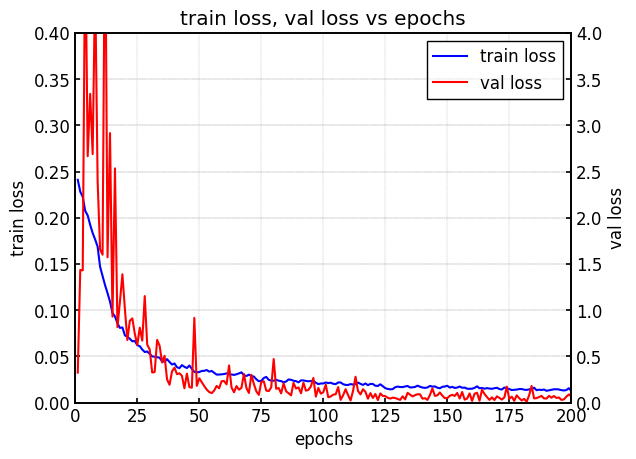

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

# 全体設定
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 1.2
plt.rcParams['ytick.major.width'] = 1.2
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['axes.grid']=True
plt.rcParams['grid.linestyle']='--'
plt.rcParams['grid.linewidth'] = 0.3
plt.rcParams["legend.markerscale"] = 2
plt.rcParams["legend.fancybox"] = False
plt.rcParams["legend.framealpha"] = 1
plt.rcParams["legend.edgecolor"] = 'black'

fig = plt.figure()

ax1 = fig.subplots()
ax2 = ax1.twinx()

ax1.plot(loss_df['epoch'], loss_df['train loss'], color="blue", label="train loss")
ax2.plot(loss_df['epoch'], loss_df['val loss'], c="r", label="val loss")

ax1.set_xlim(0, 200)
ax1.set_ylim(0, 0.4)
ax1.set_xlabel('epochs')
ax1.set_ylabel('train loss')

ax2.set_xlim(0, 200)
ax2.set_ylim(0, 4.0)
ax2.set_xlabel('epochs')
ax2.set_ylabel('val loss')

plt.grid(color = "gray", linestyle="dotted")

plt.title("train loss, val loss vs epochs")
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2)

plt.show()